<a href="https://colab.research.google.com/github/victordotm/TFM/blob/master/Entrenar_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
BASE_FOLDER = "/content/drive/My Drive/Colab Notebooks/TFM/"
BASE_FOLDER_CNN = "/content/drive/My Drive/Colab Notebooks/TFM/CNN_models/"
BASE_FOLDER_VGG16 = BASE_FOLDER+"Dataset_filtroVGG16_Imagenet-reviewed/"
BASE_FOLDER_YOLOv3 = BASE_FOLDER+"Dataset_filtroYOLOv3-reviewed/"
BASE_FOLDER_manual = BASE_FOLDER+"Dataset_manual_filter/"
BASE_FOLDER_sinFiltrar = BASE_FOLDER+"Dataset_noDup-reviewed/"
BASE_FOLDER_test = BASE_FOLDER+"Dataset_test/"

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, UpSampling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import time
import numpy as np
import pickle
from keras import models
from keras import layers
from keras import regularizers

Using TensorFlow backend.


#### Decorador: util para calcular el tiempo de ejecución de las funciones

In [0]:
#Decorador para calcular_tiempo a la función para la cual queremos calcular el tiempo de ejecución


#Función para calcular el tiempo de ejecución
def calcular_tiempo(f): # @calcular_tiempo
   
    def wrapper(*args, **kwargs):        
        inicio = time.time()       
        resultado = f(*args, **kwargs)       
        tiempo = time.time() - inicio
        print("Tiempo de ejecución para algoritmo: "+str(tiempo))
        return resultado
    
    return wrapper

## Definición funciones utiles

#### Definición función cargar base de datos pickle

In [0]:
def cargar_base_datos(folder, nombre):
  
  pickle_in = open(folder+"Imag"+nombre+".pickle","rb")
  X = pickle.load(pickle_in)

  pickle_in = open(folder+"Label"+nombre+".pickle","rb")
  y = pickle.load(pickle_in)

  #El valor de labels de la base de datos es string. Lo debemos convertir en numerico para que nuestro modelo neuronal pueda trabajar con él.

  le = preprocessing.LabelEncoder()
  le.fit(y)
  y=le.transform(y)

  #Ordenamos al azar los ejemplos, para evitar que los datos esten ordenados por clases, lo que provocaria un error de entrenamiento
  #Si no lo hacemos, hemos visto como el modelo entrenado, luego no sirve para predecir.

  np.random.seed(10) #Fijamos una semilla para el random para poder reproducir los mismos resultados. 
  np.random.shuffle(X)
  np.random.seed(10)
  np.random.shuffle(y)
  
  #Convertimos las etiquetas a valores categoricos para que la CNN los pueda interpretar
  y = to_categorical(y)
  
  # Dividimos los datos en 2 partes: Una para training y la otra para testear y verificar el modelo.

  n_train = int(0.9 * X.shape[0]) #90% de datos para training y 10% para test
  X_train, X_test = X[:n_train, :], X[n_train:, :]
  y_train, y_test = y[:n_train], y[n_train:]

  #La parte de validación esta incluida en la parte de training, la dividiremos dentro de entrenar_CNN
  
  return X_train, y_train, X_test, y_test

#### Definición crear gráfica perdida y accuracy entrenamiento CNN

In [0]:
def plot_loss (CNN_history):
  
  #plot loss
  epochs = np.arange(1,len(CNN_history.history['loss'])+1)
  plt.title('Loss over training')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.plot(epochs,CNN_history.history['loss'],'r',label='training loss')
  plt.plot(epochs,CNN_history.history['val_loss'],'b',label='validation loss')
  plt.legend(loc='best')
  plt.show()
  
  return True

In [0]:
def plot_accuracy (CNN_history):
  
  #plot accuracy
  epochs = np.arange(1,len(CNN_history.history['acc'])+1)
  plt.title('Accuracy over training')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.plot(epochs,CNN_history.history['acc'],'r',label='training accuracy')
  plt.plot(epochs,CNN_history.history['val_acc'],'b',label='validation accuracy')
  plt.legend(loc='best')
  plt.show()
  
  return True

#### Función evaluar CNN

In [0]:
def evaluar_CNN (model, eva_data, eva_label):

  loss,accuracy = model.evaluate(eva_data,eva_label)
  print('loss {}'.format(loss))
  print('acuracy {} '.format(accuracy))
  
  return True

#### Definición variables

In [0]:
#Categorias completas / sin balancear
pick_name_std_ub_complet = "std_ub_c"
pick_name_Aug4_ub_complet = "Aug4_ub_c"
pick_name_Aug6_ub_complet = "Aug6_ub_c"
pick_name_AugMx_ub_complet = "AugMx_ub_c"


#Categorias completas / balanceadas
pick_name_low_bal = "low_bal"
pick_name_medium_bal = "medium_bal"
pick_name_high_bal = "high_bal"

#Nombre base de datos
YOLOv3 = "_YOLOv3"
VGG16 = "_VGG16"
manual = "_Manual_Filter"
nofil = "_No_filter"



#### Función entrenar CNN

In [0]:
@calcular_tiempo
def entrenar_CNN (CNN, datos, labels, num_epochs, size_batch, CNN_name, data_name, type_name, carpeta_base=BASE_FOLDER_CNN):
  
  # Adequamos/entrenamos nuestro modelo de red neuronal a nuestros datos
  history_CNN = CNN.fit(datos, labels,epochs=num_epochs,batch_size=size_batch,validation_split=0.2,shuffle = True)
  CNN.save(carpeta_base+CNN_name+data_name+type_name+".h5py")
  
  return history_CNN

### Diseño red neuronal
<br>
Basados en los resultados del notebook diseño CNN, replicamos el diseño com mejores métricas.

In [0]:

def diseño_red():
  CNN = models.Sequential()
  CNN.add(layers.Conv2D(128,(3,3),input_shape=(104,104,3),activation='tanh')) 
  CNN.add(layers.MaxPooling2D((2,2)))
  CNN.add(layers.Conv2D(128,(3,3),activation='tanh'))
  CNN.add(layers.MaxPooling2D((2,2)))
  CNN.add(layers.Conv2D(128,(3,3),activation='tanh'))

  CNN.add(layers.MaxPooling2D((2,2)))
  CNN.add(layers.Dropout(0.25))
  CNN.add(layers.Dense(200,activation='tanh',kernel_regularizer=regularizers.l2(0.001)))
  CNN.add(layers.MaxPooling2D((3,3)))

  CNN.add(layers.Flatten())
  CNN.add(layers.Dense(512,activation='tanh')) 
  #Eliminamos una capa densa

  #capa final: 6 conexiones ya que clasificamos las imagenes en 6 categorias
  CNN.add(layers.Dense(6,activation='softmax'))

  CNN.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
  
  return CNN

In [0]:
CNN = "CNN"

def entrenar_modelo(carpeta_base, tipo_baseDatos, nombre_baseDatos, CNN, epochs=180, batch=18):
  
  red = diseño_red() #Compilamos de nuevo la CNN
  
  print("Cargamos base de datos")
  X_train, y_train, X_test, y_test = cargar_base_datos(carpeta_base, tipo_baseDatos) #Cargar base de datos + split entrenamiento y validación

  print("Entrenamos CNN")
  CNN_history = entrenar_CNN (red, X_train, y_train, epochs, batch, CNN, nombre_baseDatos, tipo_baseDatos)

  print("")
  print("")
  print("")
  print("Evaluamos CNN")
  print("------------------------")
  evaluar_CNN (red, X_test, y_test)

  return CNN_history


#Entrenamiento red neuronal
<br>
Entrenamos la CNN con las diferentes bases de datos que hemos creado para posteriormente comparar sus resultados

## CNN entrenada con base de datos VGG16

In [0]:
carpeta_base = BASE_FOLDER_VGG16
nombre_baseDatos = VGG16

### No data augmentation, sin balancear

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_std_ub_complet, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 279 samples, validate on 70 samples
Epoch 1/180
279/279 [==============================] - 2s 7ms/step - loss: 2.2044 - acc: 0.7312 - val_loss: 1.0782 - val_acc: 0.7571
Epoch 2/180
279/279 [==============================] - 1s 3ms/step - loss: 1.0695 - acc: 0.7993 - val_loss: 1.2705 - val_acc: 0.7571
Epoch 3/180
279/279 [==============================] - 1s 3ms/step - loss: 1.0914 - acc: 0.7993 - val_loss: 0.9729 - val_acc: 0.7571
Epoch 4/180
279/279 [==============================] - 1s 3ms/step - loss: 1.0502 - acc: 0.7993 - val_loss: 1.2369 - val_acc: 0.7571
Epoch 5/180
279/279 [==============================] - 1s 3ms/step - loss: 1.0759 - acc: 0.7993 - val_loss: 0.9915 - val_acc: 0.7571
Epoch 6/180
279/279 [==============================] - 1s 3ms/step - loss: 1.0391 - acc: 0.7993 - val_loss: 1.1151 - val_acc: 0.7571
Epoch 7/180
279/279 [==============================] - 1s 3ms/step - loss: 1.0541 - acc: 0.7993 - val_loss: 1.0189 - va

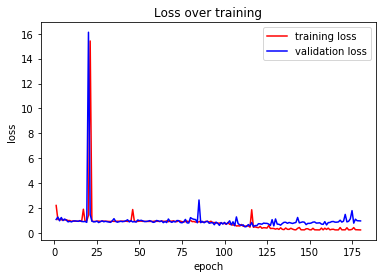

True

In [0]:
plot_loss(history)

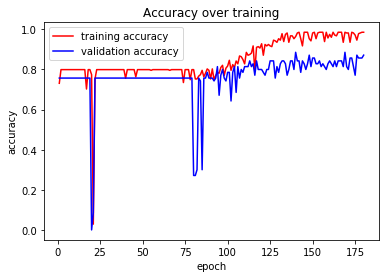

True

In [0]:
plot_accuracy(history)

### Data augmentation nivel bajo, sin balancear

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_Aug4_ub_complet, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 1116 samples, validate on 280 samples
Epoch 1/180
1116/1116 [==============================] - 5s 5ms/step - loss: 3.2524 - acc: 0.8047 - val_loss: 2.5868 - val_acc: 0.8214
Epoch 2/180
1116/1116 [==============================] - 4s 3ms/step - loss: 3.1896 - acc: 0.7912 - val_loss: 2.9045 - val_acc: 0.8214
Epoch 3/180
1116/1116 [==============================] - 4s 3ms/step - loss: 3.1729 - acc: 0.8047 - val_loss: 2.8984 - val_acc: 0.8214
Epoch 4/180
1116/1116 [==============================] - 4s 3ms/step - loss: 3.1584 - acc: 0.7912 - val_loss: 8.5499 - val_acc: 0.0000e+00
Epoch 5/180
1116/1116 [==============================] - 4s 3ms/step - loss: 2.1811 - acc: 0.7894 - val_loss: 2.0176 - val_acc: 0.8214
Epoch 6/180
1116/1116 [==============================] - 4s 3ms/step - loss: 2.0420 - acc: 0.8047 - val_loss: 1.8600 - val_acc: 0.8214
Epoch 7/180
1116/1116 [==============================] - 4s 3ms/step - loss: 2.0309 - acc: 0.8047 - v

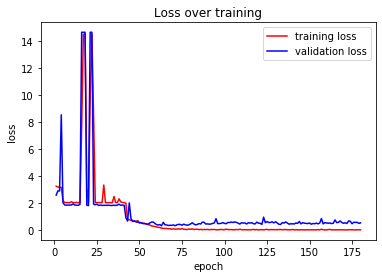

True

In [0]:
plot_loss(history)

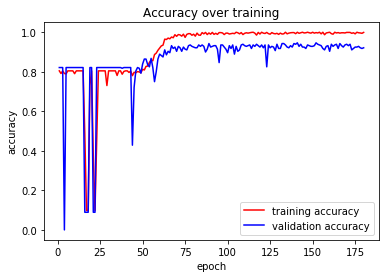

True

In [0]:
plot_accuracy(history)

### Data augmentation nivel medio, sin balancear

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_Aug6_ub_complet , nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 2513 samples, validate on 629 samples
Epoch 1/180
2513/2513 [==============================] - 9s 4ms/step - loss: 7.4732 - acc: 0.5249 - val_loss: 13.2449 - val_acc: 0.0397
Epoch 2/180
2513/2513 [==============================] - 8s 3ms/step - loss: 1.0909 - acc: 0.7732 - val_loss: 0.8527 - val_acc: 0.7933
Epoch 3/180
2513/2513 [==============================] - 8s 3ms/step - loss: 0.8366 - acc: 0.7911 - val_loss: 0.8321 - val_acc: 0.7933
Epoch 4/180
2513/2513 [==============================] - 8s 3ms/step - loss: 0.8107 - acc: 0.7907 - val_loss: 0.7551 - val_acc: 0.7933
Epoch 5/180
2513/2513 [==============================] - 8s 3ms/step - loss: 0.8183 - acc: 0.7951 - val_loss: 0.7881 - val_acc: 0.7901
Epoch 6/180
2513/2513 [==============================] - 8s 3ms/step - loss: 0.8757 - acc: 0.7704 - val_loss: 0.8053 - val_acc: 0.7933
Epoch 7/180
2513/2513 [==============================] - 8s 3ms/step - loss: 0.8129 - acc: 0.7959 - val_

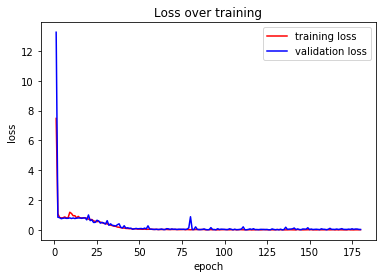

True

In [0]:
plot_loss(history)

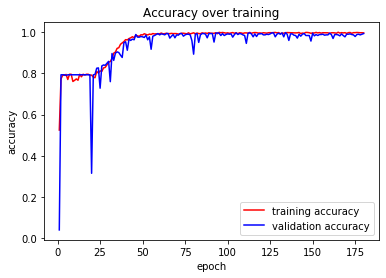

True

In [0]:
plot_accuracy(history)

### Data augmentation nivel alto, sin balancear

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_AugMx_ub_complet, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 4748 samples, validate on 1188 samples
Epoch 1/180
4748/4748 [==============================] - 17s 3ms/step - loss: 2.6729 - acc: 0.7909 - val_loss: 2.3426 - val_acc: 0.7786
Epoch 2/180
4748/4748 [==============================] - 15s 3ms/step - loss: 2.1996 - acc: 0.8031 - val_loss: 2.2641 - val_acc: 0.7786
Epoch 3/180
4748/4748 [==============================] - 15s 3ms/step - loss: 11.6279 - acc: 0.2538 - val_loss: 14.3485 - val_acc: 0.1019
Epoch 4/180
4748/4748 [==============================] - 15s 3ms/step - loss: 5.9199 - acc: 0.5859 - val_loss: 2.2595 - val_acc: 0.7786
Epoch 5/180
4748/4748 [==============================] - 15s 3ms/step - loss: 2.2080 - acc: 0.8003 - val_loss: 2.3337 - val_acc: 0.7786
Epoch 6/180
4748/4748 [==============================] - 15s 3ms/step - loss: 4.7636 - acc: 0.6563 - val_loss: 14.3347 - val_acc: 0.1019
Epoch 7/180
4748/4748 [==============================] - 15s 3ms/step - loss: 5.3233 - acc: 0.6

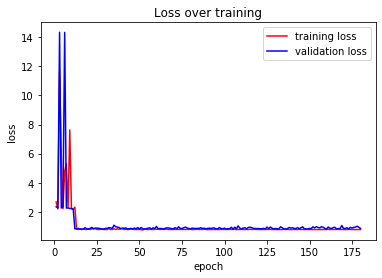

True

In [0]:
plot_loss(history)

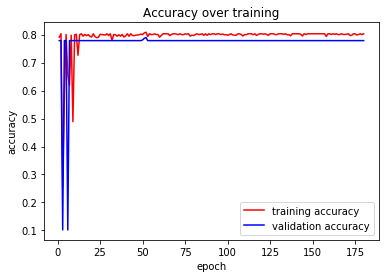

True

In [0]:
plot_accuracy(history)

### Balanceado nivel bajo

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_low_bal, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 865 samples, validate on 217 samples
Epoch 1/180
865/865 [==============================] - 5s 5ms/step - loss: 4.9130 - acc: 0.2705 - val_loss: 2.5592 - val_acc: 0.3963
Epoch 2/180
865/865 [==============================] - 3s 3ms/step - loss: 1.8053 - acc: 0.3572 - val_loss: 2.3638 - val_acc: 0.2488
Epoch 3/180
865/865 [==============================] - 3s 3ms/step - loss: 1.3580 - acc: 0.5341 - val_loss: 1.6906 - val_acc: 0.5899
Epoch 4/180
865/865 [==============================] - 3s 3ms/step - loss: 0.9805 - acc: 0.6786 - val_loss: 1.6411 - val_acc: 0.5207
Epoch 5/180
865/865 [==============================] - 3s 3ms/step - loss: 0.7856 - acc: 0.7480 - val_loss: 1.1642 - val_acc: 0.7005
Epoch 6/180
865/865 [==============================] - 3s 3ms/step - loss: 0.5736 - acc: 0.8312 - val_loss: 1.4268 - val_acc: 0.6221
Epoch 7/180
865/865 [==============================] - 3s 3ms/step - loss: 0.5758 - acc: 0.8393 - val_loss: 0.8540 - v

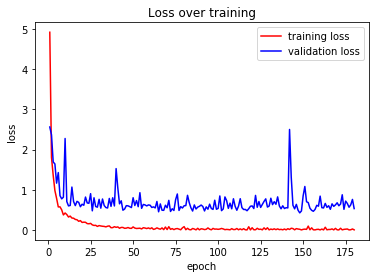

True

In [0]:
plot_loss(history)

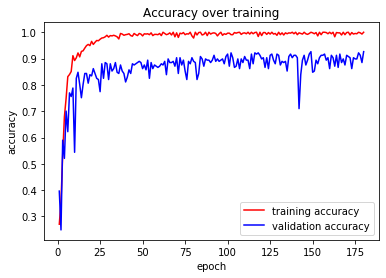

True

In [0]:
plot_accuracy(history)

### Balanceado nivel medio

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_medium_bal, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 2160 samples, validate on 541 samples
Epoch 1/180
2160/2160 [==============================] - 9s 4ms/step - loss: 4.6061 - acc: 0.1685 - val_loss: 4.3965 - val_acc: 0.1664
Epoch 2/180
2160/2160 [==============================] - 7s 3ms/step - loss: 3.8808 - acc: 0.3426 - val_loss: 3.9858 - val_acc: 0.4140
Epoch 3/180
2160/2160 [==============================] - 7s 3ms/step - loss: 2.7311 - acc: 0.5116 - val_loss: 0.9855 - val_acc: 0.6063
Epoch 4/180
2160/2160 [==============================] - 7s 3ms/step - loss: 0.8177 - acc: 0.7333 - val_loss: 1.0288 - val_acc: 0.6470
Epoch 5/180
2160/2160 [==============================] - 7s 3ms/step - loss: 0.5813 - acc: 0.8222 - val_loss: 0.6448 - val_acc: 0.8226
Epoch 6/180
2160/2160 [==============================] - 7s 3ms/step - loss: 0.4692 - acc: 0.8736 - val_loss: 0.5917 - val_acc: 0.8336
Epoch 7/180
2160/2160 [==============================] - 7s 3ms/step - loss: 0.3871 - acc: 0.8917 - val_l

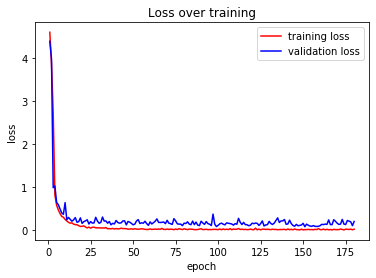

True

In [0]:
plot_loss(history)

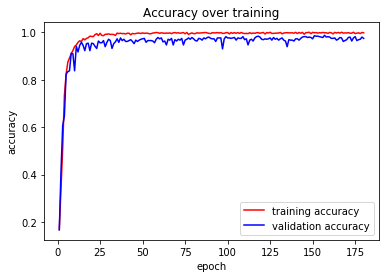

True

In [0]:
plot_accuracy(history)

### Balanceado nivel alto

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_high_bal, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 4320 samples, validate on 1080 samples
Epoch 1/180
4320/4320 [==============================] - 17s 4ms/step - loss: 4.2644 - acc: 0.2111 - val_loss: 4.6113 - val_acc: 0.2361
Epoch 2/180
4320/4320 [==============================] - 15s 3ms/step - loss: 1.6563 - acc: 0.5801 - val_loss: 0.7338 - val_acc: 0.7472
Epoch 3/180
4320/4320 [==============================] - 15s 3ms/step - loss: 0.5509 - acc: 0.8384 - val_loss: 0.4014 - val_acc: 0.8843
Epoch 4/180
4320/4320 [==============================] - 15s 3ms/step - loss: 0.3594 - acc: 0.9039 - val_loss: 0.4816 - val_acc: 0.8565
Epoch 5/180
4320/4320 [==============================] - 15s 3ms/step - loss: 0.2787 - acc: 0.9241 - val_loss: 0.2959 - val_acc: 0.9083
Epoch 6/180
4320/4320 [==============================] - 15s 3ms/step - loss: 0.2154 - acc: 0.9447 - val_loss: 0.2007 - val_acc: 0.9444
Epoch 7/180
4320/4320 [==============================] - 14s 3ms/step - loss: 0.1710 - acc: 0.9606

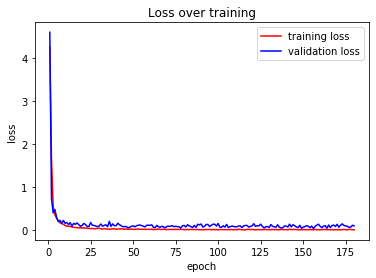

True

In [0]:
plot_loss(history)

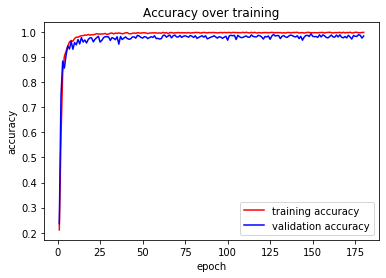

True

In [0]:
plot_accuracy(history)

## CNN entrenada con base de datos YOLOv3

In [0]:
carpeta_base = BASE_FOLDER_YOLOv3
nombre_baseDatos = YOLOv3

### No data augmentation, sin balancear

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_std_ub_complet, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 676 samples, validate on 169 samples
Epoch 1/180
676/676 [==============================] - 4s 6ms/step - loss: 4.6931 - acc: 0.4083 - val_loss: 4.3797 - val_acc: 0.0178
Epoch 2/180
676/676 [==============================] - 2s 3ms/step - loss: 4.1213 - acc: 0.4675 - val_loss: 3.6568 - val_acc: 0.5148
Epoch 3/180
676/676 [==============================] - 2s 3ms/step - loss: 4.0976 - acc: 0.4601 - val_loss: 3.5167 - val_acc: 0.5148
Epoch 4/180
676/676 [==============================] - 2s 3ms/step - loss: 4.0317 - acc: 0.4852 - val_loss: 3.4961 - val_acc: 0.5148
Epoch 5/180
676/676 [==============================] - 2s 3ms/step - loss: 4.0133 - acc: 0.4408 - val_loss: 3.3882 - val_acc: 0.5148
Epoch 6/180
676/676 [==============================] - 2s 3ms/step - loss: 4.0297 - acc: 0.4852 - val_loss: 3.4193 - val_acc: 0.5148
Epoch 7/180
676/676 [==============================] - 2s 3ms/step - loss: 3.9842 - acc: 0.4867 - val_loss: 3.4779 - v

In [0]:
plot_loss(history)

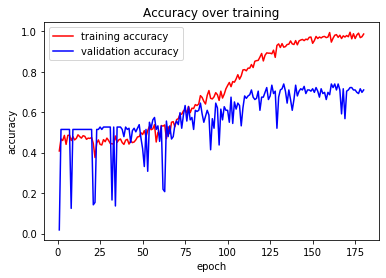

True

In [0]:
plot_accuracy(history)

### Data augmentation nivel bajo, sin balancear

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_Aug4_ub_complet, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 2704 samples, validate on 676 samples
Epoch 1/180
2704/2704 [==============================] - 12s 4ms/step - loss: 6.4591 - acc: 0.4789 - val_loss: 2.4297 - val_acc: 0.4882
Epoch 2/180
2704/2704 [==============================] - 9s 3ms/step - loss: 2.0445 - acc: 0.4686 - val_loss: 2.5192 - val_acc: 0.1775
Epoch 3/180
2704/2704 [==============================] - 9s 3ms/step - loss: 2.0564 - acc: 0.4656 - val_loss: 2.2919 - val_acc: 0.4882
Epoch 4/180
2704/2704 [==============================] - 9s 3ms/step - loss: 2.0091 - acc: 0.4719 - val_loss: 2.2399 - val_acc: 0.4882
Epoch 5/180
2704/2704 [==============================] - 9s 3ms/step - loss: 2.0153 - acc: 0.4656 - val_loss: 2.4755 - val_acc: 0.1095
Epoch 6/180
2704/2704 [==============================] - 9s 3ms/step - loss: 4.3935 - acc: 0.3861 - val_loss: 2.3149 - val_acc: 0.4882
Epoch 7/180
2704/2704 [==============================] - 9s 3ms/step - loss: 6.7625 - acc: 0.3203 - val_

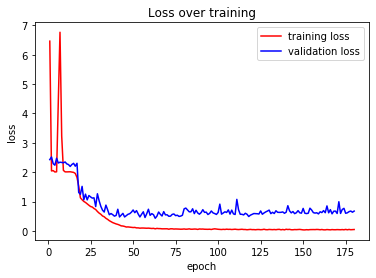

True

In [0]:
plot_loss(history)

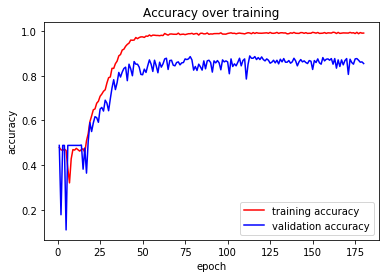

True

In [0]:
plot_accuracy(history)

### Data augmentation nivel medio, sin balancear

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_Aug6_ub_complet , nombre_baseDatos, CNN)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Cargamos base de datos
Entrenamos CNN
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 6084 samples, validate on 1521 samples
Epoch 1/180





6084/6084 [==============================] - 32s 5ms/step - loss: 7.7428 - acc: 0.2060 - val_loss: 1.4432 - val_acc: 0.4924
Epoch 2/180
6084/6084 [==============================] - 23s 4ms/step - loss: 1.4583 - acc: 0.4852 - val_loss: 1.3942 - val_acc: 0.4760
Epoch 3/180
6084/6084 [==============================] - 23s 4ms/step - loss: 1.1920 - acc: 0.5784 - val_loss: 1.2294 - val_acc: 0.5707
Epoch 4/180
6084/6084 [==============================] - 23s 4ms/step - loss: 1.0036 - acc: 0.6492 - val_loss: 1.0666 - val_acc: 0.6430
Epoch 5/180
6084/6084 [==============================] - 23s 4ms/step - loss: 0.8519 - acc: 0.7064 - val_loss: 0.7303 - val_acc: 0.7567
Epoch 6/18

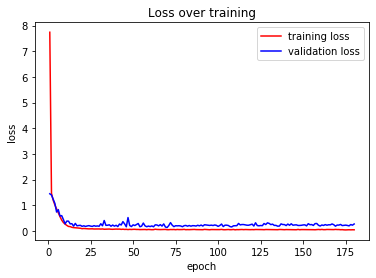

True

In [0]:
plot_loss(history)

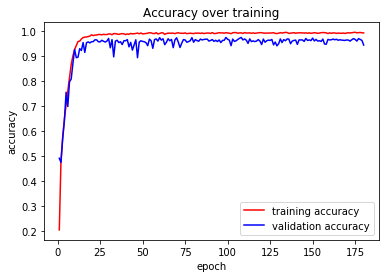

True

In [0]:
plot_accuracy(history)

### Data augmentation nivel alto, sin balancear

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_AugMx_ub_complet, nombre_baseDatos, CNN)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Cargamos base de datos
Entrenamos CNN
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 11492 samples, validate on 2874 samples
Epoch 1/180





11492/11492 [==============================] - 59s 5ms/step - loss: 7.8918 - acc: 0.1977 - val_loss: 2.3490 - val_acc: 0.4756
Epoch 2/180
11492/11492 [==============================] - 48s 4ms/step - loss: 2.0474 - acc: 0.4706 - val_loss: 2.2454 - val_acc: 0.4767
Epoch 3/180
11492/11492 [==============================] - 48s 4ms/step - loss: 2.0562 - acc: 0.4688 - val_loss: 2.2006 - val_acc: 0.4749
Epoch 4/180
11492/11492 [==============================] - 48s 4ms/step - loss: 1.6718 - acc: 0.4690 - val_loss: 1.4021 - val_acc: 0.4927
Epoch 5/180
11492/11492 [==============================] - 48s 4ms/step - loss: 1.0530 - acc: 0.6069 - val_loss: 1.1820 - val_acc: 0.5195

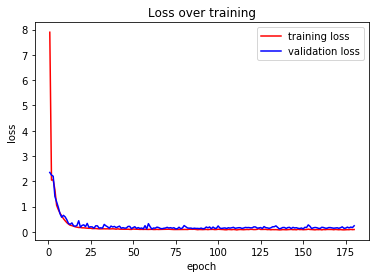

True

In [0]:
plot_loss(history)

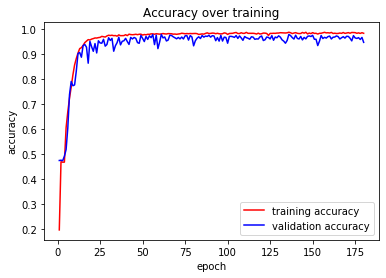

True

In [0]:
plot_accuracy(history)

### Balanceado nivel bajo

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_low_bal, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 868 samples, validate on 218 samples
Epoch 1/180
868/868 [==============================] - 4s 4ms/step - loss: 4.6551 - acc: 0.1809 - val_loss: 3.9384 - val_acc: 0.2202
Epoch 2/180
868/868 [==============================] - 3s 3ms/step - loss: 4.1567 - acc: 0.2454 - val_loss: 3.9354 - val_acc: 0.1743
Epoch 3/180
868/868 [==============================] - 3s 3ms/step - loss: 4.0713 - acc: 0.2730 - val_loss: 3.8802 - val_acc: 0.3211
Epoch 4/180
868/868 [==============================] - 3s 3ms/step - loss: 4.0546 - acc: 0.2558 - val_loss: 4.6691 - val_acc: 0.2798
Epoch 5/180
868/868 [==============================] - 3s 3ms/step - loss: 4.0174 - acc: 0.2765 - val_loss: 4.0252 - val_acc: 0.2798
Epoch 6/180
868/868 [==============================] - 3s 3ms/step - loss: 3.9808 - acc: 0.2995 - val_loss: 3.8344 - val_acc: 0.3532
Epoch 7/180
868/868 [==============================] - 3s 3ms/step - loss: 3.9490 - acc: 0.3168 - val_loss: 3.8234 - v

In [0]:
plot_loss(history)

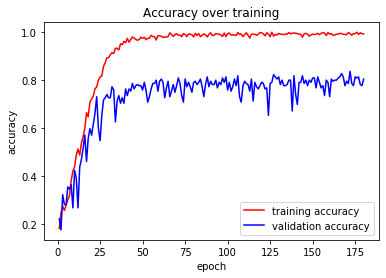

True

In [0]:
plot_accuracy(history)

### Balanceado nivel medio

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_medium_bal, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 2161 samples, validate on 541 samples
Epoch 1/180
2161/2161 [==============================] - 8s 4ms/step - loss: 6.4440 - acc: 0.2258 - val_loss: 6.6356 - val_acc: 0.3124
Epoch 2/180
2161/2161 [==============================] - 7s 3ms/step - loss: 6.3516 - acc: 0.2471 - val_loss: 6.3547 - val_acc: 0.3050
Epoch 3/180
2161/2161 [==============================] - 7s 3ms/step - loss: 6.2903 - acc: 0.2476 - val_loss: 6.5007 - val_acc: 0.3105
Epoch 4/180
2161/2161 [==============================] - 7s 3ms/step - loss: 6.2484 - acc: 0.2596 - val_loss: 6.6090 - val_acc: 0.2200
Epoch 5/180
2161/2161 [==============================] - 7s 3ms/step - loss: 6.2430 - acc: 0.2615 - val_loss: 6.7631 - val_acc: 0.1627
Epoch 6/180
2161/2161 [==============================] - 7s 3ms/step - loss: 6.2252 - acc: 0.2661 - val_loss: 7.3301 - val_acc: 0.1553
Epoch 7/180
2161/2161 [==============================] - 7s 3ms/step - loss: 6.6968 - acc: 0.2582 - val_l

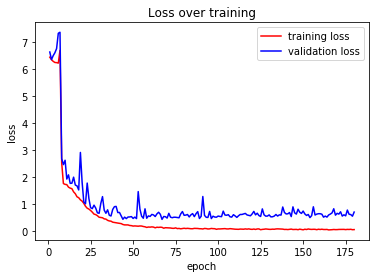

True

In [0]:
plot_loss(history)

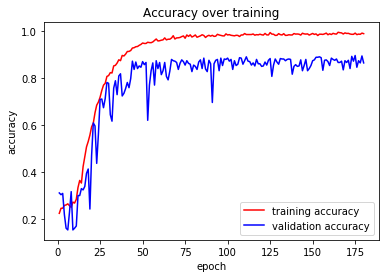

True

In [0]:
plot_accuracy(history)

### Balanceado nivel alto

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_high_bal, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 4320 samples, validate on 1081 samples
Epoch 1/180
4320/4320 [==============================] - 15s 4ms/step - loss: 5.5040 - acc: 0.2046 - val_loss: 2.0499 - val_acc: 0.1684
Epoch 2/180
4320/4320 [==============================] - 14s 3ms/step - loss: 1.8596 - acc: 0.2366 - val_loss: 1.8270 - val_acc: 0.2405
Epoch 3/180
4320/4320 [==============================] - 14s 3ms/step - loss: 1.7050 - acc: 0.3188 - val_loss: 1.6634 - val_acc: 0.3608
Epoch 4/180
4320/4320 [==============================] - 14s 3ms/step - loss: 1.4132 - acc: 0.4565 - val_loss: 1.2764 - val_acc: 0.4838
Epoch 5/180
4320/4320 [==============================] - 14s 3ms/step - loss: 1.2254 - acc: 0.5426 - val_loss: 1.1347 - val_acc: 0.5698
Epoch 6/180
4320/4320 [==============================] - 14s 3ms/step - loss: 0.9901 - acc: 0.6414 - val_loss: 1.0141 - val_acc: 0.6401
Epoch 7/180
4320/4320 [==============================] - 14s 3ms/step - loss: 0.7874 - acc: 0.7222

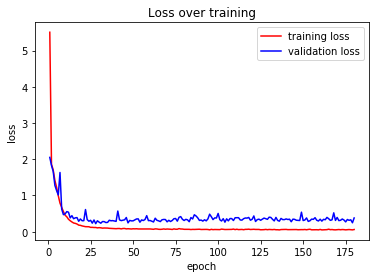

True

In [0]:
plot_loss(history)

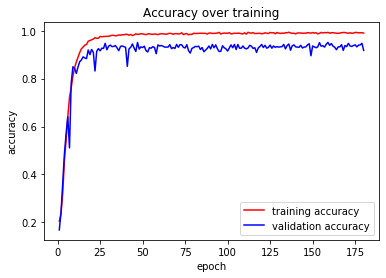

True

In [0]:
plot_accuracy(history)

## CNN entrenada con base de datos filtrado manual

In [0]:
carpeta_base = BASE_FOLDER_manual
nombre_baseDatos = manual

### No data augmentation, sin balancear

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_std_ub_complet, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 756 samples, validate on 190 samples
Epoch 1/180
756/756 [==============================] - 3s 4ms/step - loss: 3.7437 - acc: 0.3373 - val_loss: 2.4664 - val_acc: 0.2158
Epoch 2/180
756/756 [==============================] - 2s 3ms/step - loss: 1.7329 - acc: 0.4008 - val_loss: 1.6293 - val_acc: 0.4632
Epoch 3/180
756/756 [==============================] - 2s 3ms/step - loss: 1.6791 - acc: 0.4087 - val_loss: 1.6199 - val_acc: 0.2158
Epoch 4/180
756/756 [==============================] - 2s 3ms/step - loss: 1.6546 - acc: 0.3902 - val_loss: 1.5528 - val_acc: 0.4632
Epoch 5/180
756/756 [==============================] - 2s 3ms/step - loss: 1.7363 - acc: 0.4061 - val_loss: 1.5654 - val_acc: 0.4632
Epoch 6/180
756/756 [==============================] - 2s 3ms/step - loss: 1.6558 - acc: 0.4101 - val_loss: 1.6479 - val_acc: 0.4632
Epoch 7/180
756/756 [==============================] - 2s 3ms/step - loss: 1.6654 - acc: 0.3836 - val_loss: 1.4959 - v

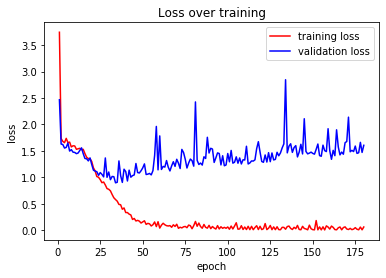

True

In [0]:
plot_loss(history)

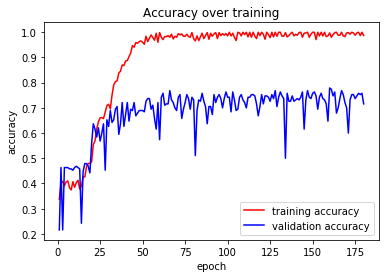

True

In [0]:
plot_accuracy(history)

### Data augmentation nivel bajo, sin balancear

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_Aug4_ub_complet, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 3029 samples, validate on 758 samples
Epoch 1/180
3029/3029 [==============================] - 11s 4ms/step - loss: 8.6383 - acc: 0.2747 - val_loss: 10.6694 - val_acc: 0.0607
Epoch 2/180
3029/3029 [==============================] - 10s 3ms/step - loss: 8.1064 - acc: 0.1641 - val_loss: 8.0364 - val_acc: 0.1926
Epoch 3/180
3029/3029 [==============================] - 10s 3ms/step - loss: 8.0610 - acc: 0.1684 - val_loss: 8.4808 - val_acc: 0.0607
Epoch 4/180
3029/3029 [==============================] - 10s 3ms/step - loss: 8.0671 - acc: 0.1601 - val_loss: 8.0854 - val_acc: 0.1240
Epoch 5/180
3029/3029 [==============================] - 10s 3ms/step - loss: 8.0608 - acc: 0.1618 - val_loss: 8.0264 - val_acc: 0.1636
Epoch 6/180
3029/3029 [==============================] - 10s 3ms/step - loss: 8.0618 - acc: 0.1664 - val_loss: 8.0536 - val_acc: 0.1926
Epoch 7/180
3029/3029 [==============================] - 10s 3ms/step - loss: 8.7064 - acc: 0.3338

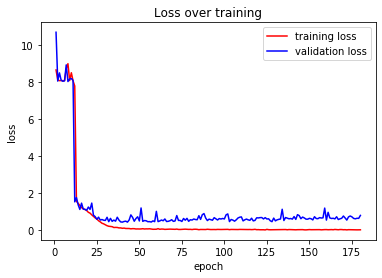

True

In [0]:
plot_loss(history)

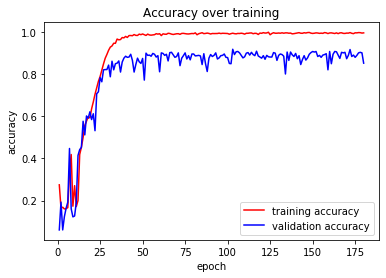

True

In [0]:
plot_accuracy(history)

### Data augmentation nivel medio, sin balancear

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_Aug6_ub_complet , nombre_baseDatos, CNN)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Cargamos base de datos
Entrenamos CNN
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 6816 samples, validate on 1705 samples
Epoch 1/180





6816/6816 [==============================] - 31s 5ms/step - loss: 3.4056 - acc: 0.4139 - val_loss: 1.4843 - val_acc: 0.4786
Epoch 2/180
6816/6816 [==============================] - 27s 4ms/step - loss: 1.6155 - acc: 0.3866 - val_loss: 1.5228 - val_acc: 0.4786
Epoch 3/180
6816/6816 [==============================] - 27s 4ms/step - loss: 1.5993 - acc: 0.4021 - val_loss: 1.5558 - val_acc: 0.4786
Epoch 4/180
6816/6816 [==============================] - 27s 4ms/step - loss: 1.5768 - acc: 0.4077 - val_loss: 1.4645 - val_acc: 0.4786
Epoch 5/180
6816/6816 [==============================] - 27s 4ms/step - loss: 1.5903 - acc: 0.4061 - val_loss: 1.5660 - val_acc: 0.4786
Epoch 6/18

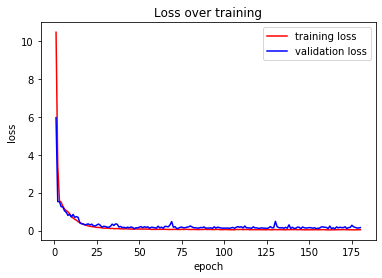

True

In [0]:
plot_loss(history)

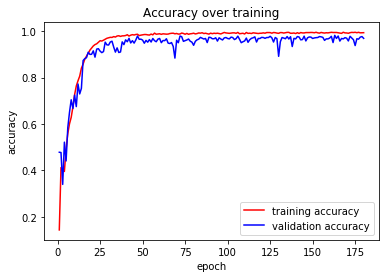

True

In [0]:
plot_accuracy(history)

### Data augmentation nivel alto, sin balancear

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_AugMx_ub_complet, nombre_baseDatos, CNN)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Cargamos base de datos
Entrenamos CNN
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 9846 samples, validate on 2462 samples
Epoch 1/180





9846/9846 [==============================] - 52s 5ms/step - loss: 2.3393 - acc: 0.4095 - val_loss: 2.3151 - val_acc: 0.4472
Epoch 2/180
9846/9846 [==============================] - 41s 4ms/step - loss: 2.2661 - acc: 0.4134 - val_loss: 2.3041 - val_acc: 0.4472
Epoch 3/180
9846/9846 [==============================] - 41s 4ms/step - loss: 2.3366 - acc: 0.3984 - val_loss: 2.3403 - val_acc: 0.3631
Epoch 4/180
9846/9846 [==============================] - 41s 4ms/step - loss: 1.7653 - acc: 0.4633 - val_loss: 1.3169 - val_acc: 0.4496
Epoch 5/180
9846/9846 [==============================] - 41s 4ms/step - loss: 1.1643 - acc: 0.5594 - val_loss: 1.0704 - val_acc: 0.6202
Epoch 6/18

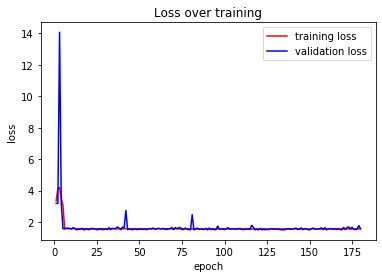

True

In [0]:
plot_loss(history)

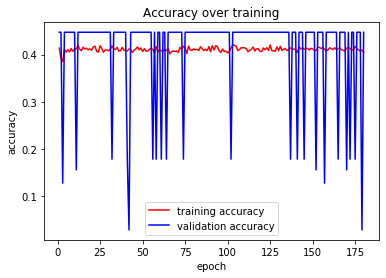

True

In [0]:
plot_accuracy(history)

### Balanceado nivel bajo

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_low_bal, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 867 samples, validate on 217 samples
Epoch 1/180
867/867 [==============================] - 4s 4ms/step - loss: 4.7377 - acc: 0.1719 - val_loss: 4.3132 - val_acc: 0.2074
Epoch 2/180
867/867 [==============================] - 3s 3ms/step - loss: 4.2536 - acc: 0.1742 - val_loss: 4.6457 - val_acc: 0.1198
Epoch 3/180
867/867 [==============================] - 3s 3ms/step - loss: 4.1958 - acc: 0.2053 - val_loss: 5.4712 - val_acc: 0.2074
Epoch 4/180
867/867 [==============================] - 3s 3ms/step - loss: 3.8555 - acc: 0.2157 - val_loss: 6.6900 - val_acc: 0.1382
Epoch 5/180
867/867 [==============================] - 3s 3ms/step - loss: 1.9535 - acc: 0.2641 - val_loss: 2.4089 - val_acc: 0.2995
Epoch 6/180
867/867 [==============================] - 3s 3ms/step - loss: 1.8012 - acc: 0.2976 - val_loss: 1.7532 - val_acc: 0.4378
Epoch 7/180
867/867 [==============================] - 3s 3ms/step - loss: 1.7355 - acc: 0.3426 - val_loss: 2.0535 - v

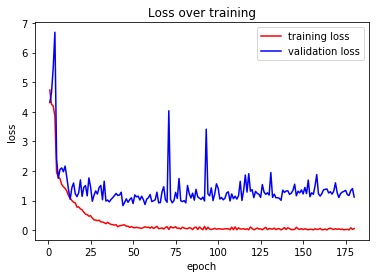

True

In [0]:
plot_loss(history)

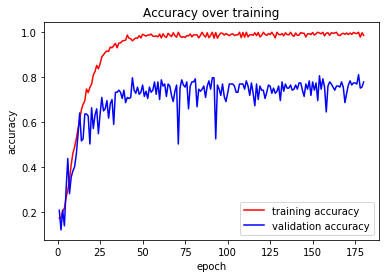

True

In [0]:
plot_accuracy(history)

### Balanceado nivel medio

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_medium_bal, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 2160 samples, validate on 541 samples
Epoch 1/180
2160/2160 [==============================] - 8s 4ms/step - loss: 5.3488 - acc: 0.2130 - val_loss: 4.2015 - val_acc: 0.1867
Epoch 2/180
2160/2160 [==============================] - 7s 3ms/step - loss: 4.1029 - acc: 0.2523 - val_loss: 4.4248 - val_acc: 0.1867
Epoch 3/180
2160/2160 [==============================] - 7s 3ms/step - loss: 3.9748 - acc: 0.2977 - val_loss: 4.1445 - val_acc: 0.2458
Epoch 4/180
2160/2160 [==============================] - 7s 3ms/step - loss: 3.8621 - acc: 0.3495 - val_loss: 3.8646 - val_acc: 0.4104
Epoch 5/180
2160/2160 [==============================] - 7s 3ms/step - loss: 3.7333 - acc: 0.4218 - val_loss: 3.8042 - val_acc: 0.4677
Epoch 6/180
2160/2160 [==============================] - 7s 3ms/step - loss: 3.2869 - acc: 0.4898 - val_loss: 1.3365 - val_acc: 0.5305
Epoch 7/180
2160/2160 [==============================] - 7s 3ms/step - loss: 1.2527 - acc: 0.5616 - val_l

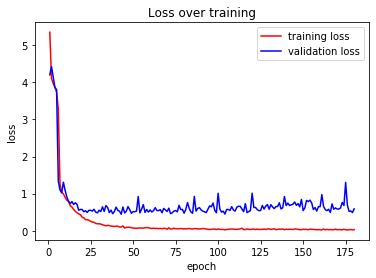

True

In [0]:
plot_loss(history)

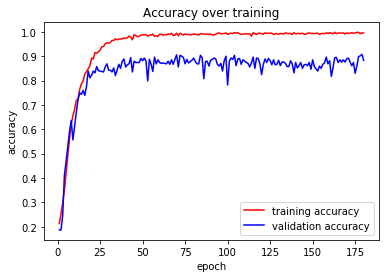

True

In [0]:
plot_accuracy(history)

### Balanceado nivel alto

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_high_bal, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 4320 samples, validate on 1080 samples
Epoch 1/180
4320/4320 [==============================] - 15s 3ms/step - loss: 2.5868 - acc: 0.1951 - val_loss: 2.0001 - val_acc: 0.1519
Epoch 2/180
4320/4320 [==============================] - 14s 3ms/step - loss: 1.8070 - acc: 0.2917 - val_loss: 1.5178 - val_acc: 0.3880
Epoch 3/180
4320/4320 [==============================] - 14s 3ms/step - loss: 1.5528 - acc: 0.3963 - val_loss: 1.6518 - val_acc: 0.4065
Epoch 4/180
4320/4320 [==============================] - 14s 3ms/step - loss: 1.3534 - acc: 0.5086 - val_loss: 1.4030 - val_acc: 0.4806
Epoch 5/180
4320/4320 [==============================] - 14s 3ms/step - loss: 1.0871 - acc: 0.6162 - val_loss: 0.8850 - val_acc: 0.6889
Epoch 6/180
4320/4320 [==============================] - 14s 3ms/step - loss: 0.8978 - acc: 0.6824 - val_loss: 0.7346 - val_acc: 0.7500
Epoch 7/180
4320/4320 [==============================] - 14s 3ms/step - loss: 0.7287 - acc: 0.7447

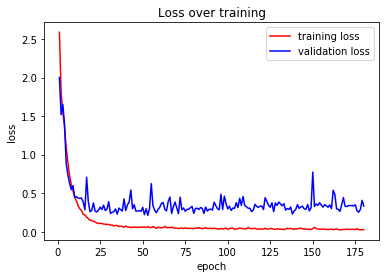

True

In [0]:
plot_loss(history)

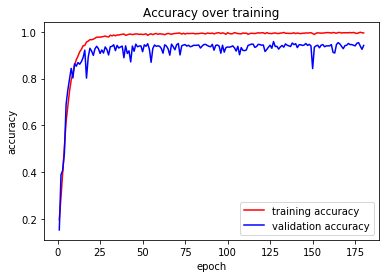

True

In [0]:
plot_accuracy(history)

## CNN entrenada con base de datos sin filtrar

In [0]:
carpeta_base = BASE_FOLDER_sinFiltrar
nombre_baseDatos = nofil

### No data augmentation, sin balancear

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_std_ub_complet, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 1569 samples, validate on 393 samples
Epoch 1/180
1569/1569 [==============================] - 6s 4ms/step - loss: 5.0795 - acc: 0.1778 - val_loss: 4.9869 - val_acc: 0.1578
Epoch 2/180
1569/1569 [==============================] - 5s 3ms/step - loss: 4.8119 - acc: 0.1918 - val_loss: 4.9212 - val_acc: 0.1247
Epoch 3/180
1569/1569 [==============================] - 5s 3ms/step - loss: 4.7874 - acc: 0.1740 - val_loss: 5.1102 - val_acc: 0.1323
Epoch 4/180
1569/1569 [==============================] - 5s 3ms/step - loss: 4.7610 - acc: 0.1880 - val_loss: 5.0360 - val_acc: 0.1323
Epoch 5/180
1569/1569 [==============================] - 5s 3ms/step - loss: 4.7588 - acc: 0.1651 - val_loss: 5.0049 - val_acc: 0.1552
Epoch 6/180
1569/1569 [==============================] - 5s 3ms/step - loss: 4.7622 - acc: 0.1804 - val_loss: 4.7562 - val_acc: 0.2239
Epoch 7/180
1569/1569 [==============================] - 5s 3ms/step - loss: 4.7443 - acc: 0.1810 - val_l

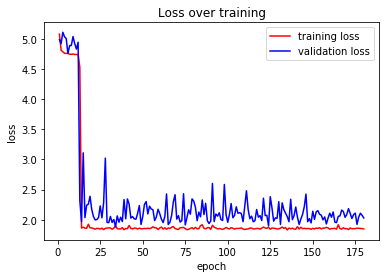

True

In [0]:
plot_loss(history)

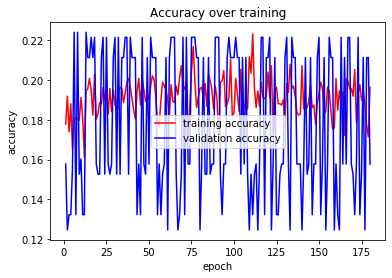

True

In [0]:
plot_accuracy(history)

### Data augmentation nivel bajo, sin balancear

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_Aug4_ub_complet, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 6278 samples, validate on 1570 samples
Epoch 1/180
6278/6278 [==============================] - 28s 4ms/step - loss: 8.6406 - acc: 0.1905 - val_loss: 8.5350 - val_acc: 0.2299
Epoch 2/180
6278/6278 [==============================] - 26s 4ms/step - loss: 3.2486 - acc: 0.1872 - val_loss: 1.9532 - val_acc: 0.1726
Epoch 3/180
6278/6278 [==============================] - 26s 4ms/step - loss: 1.8560 - acc: 0.1873 - val_loss: 1.8771 - val_acc: 0.1076
Epoch 4/180
6278/6278 [==============================] - 26s 4ms/step - loss: 1.8542 - acc: 0.1977 - val_loss: 1.8583 - val_acc: 0.1675
Epoch 5/180
6278/6278 [==============================] - 26s 4ms/step - loss: 1.8626 - acc: 0.1851 - val_loss: 1.8805 - val_acc: 0.1656
Epoch 6/180
6278/6278 [==============================] - 26s 4ms/step - loss: 1.8481 - acc: 0.1953 - val_loss: 1.7652 - val_acc: 0.2325
Epoch 7/180
6278/6278 [==============================] - 26s 4ms/step - loss: 1.8378 - acc: 0.2029

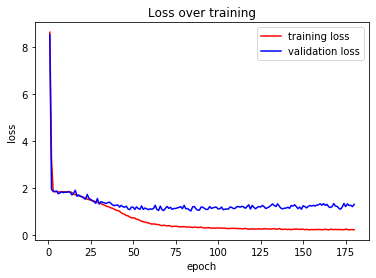

True

In [0]:
plot_loss(history)

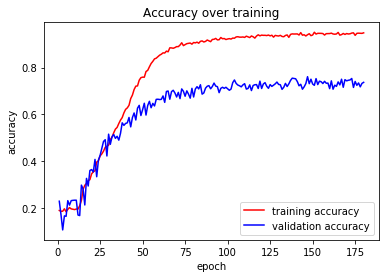

True

In [0]:
plot_accuracy(history)

### Data augmentation nivel medio, sin balancear

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_Aug6_ub_complet , nombre_baseDatos, CNN)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Cargamos base de datos
Entrenamos CNN
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 7848 samples, validate on 1962 samples
Epoch 1/180





7848/7848 [==============================] - 42s 5ms/step - loss: 4.9285 - acc: 0.1749 - val_loss: 4.8976 - val_acc: 0.1723
Epoch 2/180
7848/7848 [==============================] - 32s 4ms/step - loss: 4.7888 - acc: 0.1868 - val_loss: 4.8353 - val_acc: 0.1723
Epoch 3/180
7848/7848 [==============================] - 32s 4ms/step - loss: 4.9186 - acc: 0.1841 - val_loss: 4.8554 - val_acc: 0.2105
Epoch 4/180
7848/7848 [==============================] - 32s 4ms/step - loss: 4.8716 - acc: 0.1803 - val_loss: 4.8978 - val_acc: 0.1560
Epoch 5/180
7848/7848 [==============================] - 32s 4ms/step - loss: 7.2235 - acc: 0.1812 - val_loss: 4.8549 - val_acc: 0.1310
Epoch 6/18

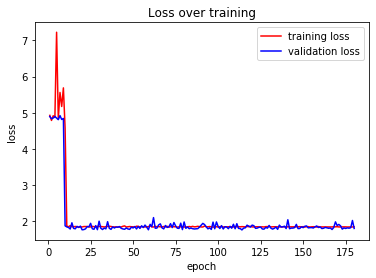

True

In [0]:
plot_loss(history)

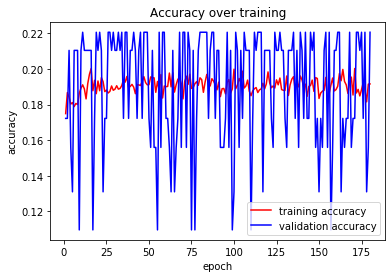

True

In [0]:
plot_accuracy(history)

### Balanceado nivel bajo

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_low_bal, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 876 samples, validate on 220 samples
Epoch 1/180
876/876 [==============================] - 4s 5ms/step - loss: 5.0202 - acc: 0.1598 - val_loss: 4.1205 - val_acc: 0.1500
Epoch 2/180
876/876 [==============================] - 3s 3ms/step - loss: 4.2875 - acc: 0.1632 - val_loss: 3.9533 - val_acc: 0.1455
Epoch 3/180
876/876 [==============================] - 3s 3ms/step - loss: 4.2945 - acc: 0.1689 - val_loss: 3.8625 - val_acc: 0.1455
Epoch 4/180
876/876 [==============================] - 3s 3ms/step - loss: 4.2756 - acc: 0.1587 - val_loss: 3.9114 - val_acc: 0.1455
Epoch 5/180
876/876 [==============================] - 3s 3ms/step - loss: 4.2011 - acc: 0.1804 - val_loss: 3.8640 - val_acc: 0.1955
Epoch 6/180
876/876 [==============================] - 3s 3ms/step - loss: 4.1934 - acc: 0.1644 - val_loss: 3.8399 - val_acc: 0.1500
Epoch 7/180
876/876 [==============================] - 3s 3ms/step - loss: 4.1937 - acc: 0.1438 - val_loss: 3.9124 - v

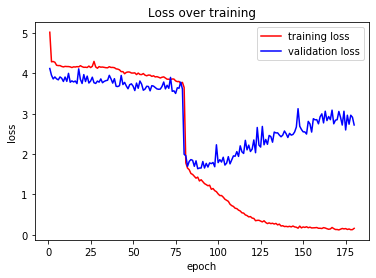

True

In [0]:
plot_loss(history)

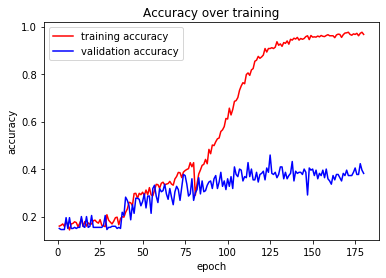

True

In [0]:
plot_accuracy(history)

### Balanceado nivel medio

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_medium_bal, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 2165 samples, validate on 542 samples
Epoch 1/180
2165/2165 [==============================] - 8s 4ms/step - loss: 4.5243 - acc: 0.1677 - val_loss: 4.5949 - val_acc: 0.1384
Epoch 2/180
2165/2165 [==============================] - 7s 3ms/step - loss: 4.1376 - acc: 0.1769 - val_loss: 4.5008 - val_acc: 0.1790
Epoch 3/180
2165/2165 [==============================] - 7s 3ms/step - loss: 4.1059 - acc: 0.1875 - val_loss: 4.3882 - val_acc: 0.1568
Epoch 4/180
2165/2165 [==============================] - 7s 3ms/step - loss: 4.0684 - acc: 0.1931 - val_loss: 4.4089 - val_acc: 0.1661
Epoch 5/180
2165/2165 [==============================] - 7s 3ms/step - loss: 3.1831 - acc: 0.1801 - val_loss: 2.2124 - val_acc: 0.1661
Epoch 6/180
2165/2165 [==============================] - 7s 3ms/step - loss: 1.8882 - acc: 0.1861 - val_loss: 2.1772 - val_acc: 0.1808
Epoch 7/180
2165/2165 [==============================] - 7s 3ms/step - loss: 1.8829 - acc: 0.1958 - val_l

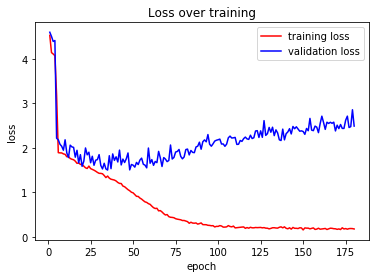

True

In [0]:
plot_loss(history)

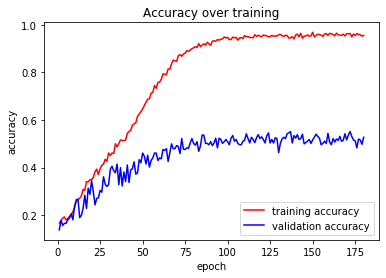

True

In [0]:
plot_accuracy(history)

### Balanceado nivel alto

In [0]:
history = entrenar_modelo(carpeta_base, pick_name_high_bal, nombre_baseDatos, CNN)

Cargamos base de datos
Entrenamos CNN
Train on 4323 samples, validate on 1081 samples
Epoch 1/180
4323/4323 [==============================] - 15s 4ms/step - loss: 4.5127 - acc: 0.1608 - val_loss: 4.2395 - val_acc: 0.1702
Epoch 2/180
4323/4323 [==============================] - 14s 3ms/step - loss: 4.1706 - acc: 0.1603 - val_loss: 4.2931 - val_acc: 0.1554
Epoch 3/180
4323/4323 [==============================] - 14s 3ms/step - loss: 4.1724 - acc: 0.1545 - val_loss: 4.0597 - val_acc: 0.1554
Epoch 4/180
4323/4323 [==============================] - 14s 3ms/step - loss: 4.1848 - acc: 0.1642 - val_loss: 4.1076 - val_acc: 0.1554
Epoch 5/180
4323/4323 [==============================] - 14s 3ms/step - loss: 4.1723 - acc: 0.1571 - val_loss: 4.0664 - val_acc: 0.1545
Epoch 6/180
4323/4323 [==============================] - 14s 3ms/step - loss: 5.5522 - acc: 0.1661 - val_loss: 3.9991 - val_acc: 0.1702
Epoch 7/180
4323/4323 [==============================] - 14s 3ms/step - loss: 6.0506 - acc: 0.1647

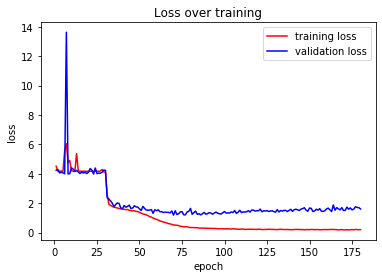

True

In [0]:
plot_loss(history)

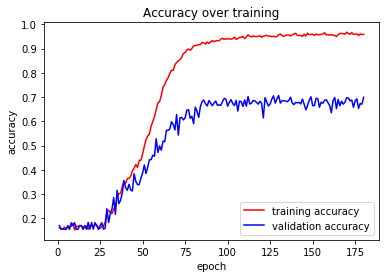

True

In [0]:
plot_accuracy(history)